<a href="https://colab.research.google.com/github/eric-pierce/MSDS-422-HW/blob/master/epierce_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Evaluating Classification Models
## MSDS-422 Spring 2019 - Eric Pierce
## Background  
A Portuguese bank conducted seventeen telephone marketing campaigns between May 2008 and November 2010. The bank recorded client contact information for each telephone call. The data collected about customers during these calls is available in the semicolon delimited file <bank.csv>.
## Objective
The bank is interested in identifying factors that affect client responses to new term deposit offerings, which are the focus of the marketing campaigns.  
*   What kinds of clients are most likely to subscribe to new term deposits?
*   What marketing approaches are most effective in encouraging clients to subscribe?
*   Which of the two modeling methods would you recommend and why?
*   Which group of banking clients appears to be the best target for direct marketing efforts? 

## Data Dictionary


| Variable Name | Description (Possible Values) | Category |
| --- | --- | --- |
| age | Age in years | Client Demographics |
| job | Type of job (admin., unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services) | Client Demographics |
| marital | Marital status (married, divorced, single) Note: “divorced” means divorced or widowed | Client Demographics |
| education | Level of education (unknown, secondary, primary, tertiary) | Client Demographics |
| default | Has credit in default? (yes, no) | Client Banking History |
| balance | Average yearly balance (in Euros) | Client Banking History |
| housing | Has housing loan? (yes, no) | Client Banking History |
| loan | Has personal loan? (yes, no) | Client Banking History |
| contact | Contact communication type (unknown, telephone, cellular) | Data from Most Recent Marketing Contact/Call |
| day | Last contact day of the month | Data from Most Recent Marketing Contact/Call |
| month | Last contact month of year (jan, feb, mar, . . ., nov, dec) | Data from Most Recent Marketing Contact/Call |
| duration | Last contact duration (in seconds) | Data from Most Recent Marketing Contact/Call |
| campaign | Number of contacts performed during this campaign for this client (includes last contact) | Data from All Marketing Contacts/Calls |
| pdays | Number of days that passed since the client was last contacted from a previous campaign (-1 means client was not previously contacted) | Data from All Marketing Contacts/Calls |
| previous | Number of contacts performed before this campaign for this client | Data from All Marketing Contacts/Calls |
| poutcome | Outcome of the previous marketing campaign (unknown, other, failure, success) | Data from All Marketing Contacts/Calls |
| response | Has the client subscribed to a term deposit? (yes, no) | Response to Most Recent Marketing Contact/Call |

# Setup and Data Import
Initialize the data and libraries used as part of this project

### Library Import and Setting Initialization

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# We'll use scikit-plot to plot visualizations of the ROC curves
!pip install scikit-plot

### Data Import

In [0]:
# Read in the bank data
bank = pd.read_csv('https://raw.githubusercontent.com/eric-pierce/MSDS-422/master/bank.csv', sep = ';')

### Initialize Model Input Array

In [0]:
# We want to use numeric identifiers for binary distictions
# This is a mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# Convert all four yes/no binary columns to 1/0 for use in analysis below 
# and ultimately in a new array for model building
bank['default_binary'] = bank['default'].map(convert_to_binary)
bank['housing_binary'] = bank['housing'].map(convert_to_binary)
bank['loan_binary'] = bank['loan'].map(convert_to_binary)
bank['response_binary'] = bank['response'].map(convert_to_binary)

# Exploratory Data Analysis
*   Clean Data
*   Identify Data Descriptions and Statistics
*   Visualize Input Data

### Clean Data

In [0]:
# examine the shape of original input data
print(bank.shape)

(4521, 21)


In [0]:
# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
print(bank.shape)

(4521, 21)


In [0]:
# look at the list of column names, note that y is the response
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response',
 'default_binary',
 'housing_binary',
 'loan_binary',
 'response_binary']

In [0]:
# look at the beginning of the DataFrame
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,response,default_binary,housing_binary,loan_binary,response_binary
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,79,1,-1,0,unknown,no,0,0,0,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,220,1,339,4,failure,no,0,1,1,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,185,1,330,1,failure,no,0,1,0,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,199,4,-1,0,unknown,no,0,1,1,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,...,226,1,-1,0,unknown,no,0,1,0,0


### Identify Data Descriptions and Statistics

In [0]:
# Identify Summary Statistics for input dataset
bank.describe()

,age,balance,day,duration,campaign,pdays,previous,default_binary,housing_binary,loan_binary,response_binary
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.016810,0.566025,0.152842,0.115240
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.128575,0.495676,0.359875,0.319347
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000,1.000000,1.000000,1.000000


### Visualize Input Data

#### Numeric Parameter Histograms

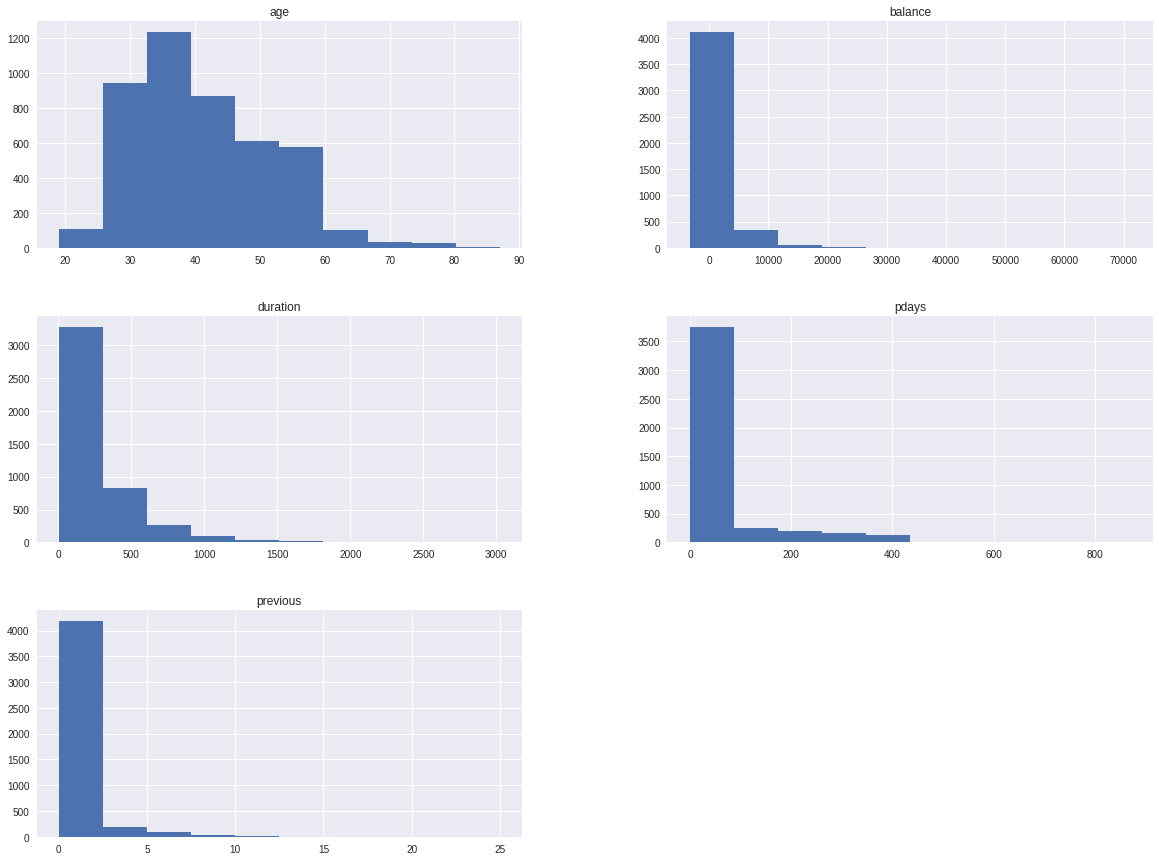

In [0]:
bank[['age','balance','duration','pdays','previous']].hist(figsize=(20,15))
plt.show()

#### Compare Average Respondees

In [0]:
# Group by Response and look at mean values across numeric attributes
bank.groupby('response').mean()

,age,balance,day,duration,campaign,pdays,previous,default_binary,housing_binary,loan_binary,response_binary
response,,,,,,,,,,,
no,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250,0.016750,0.584750,0.162000,0.0
yes,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211,0.017274,0.422265,0.082534,1.0


#### Identify Proportions associated with Response Data

In [0]:
# Percentage of Respondees in different groups
(bank['response'].value_counts() / bank['response'].count()) * 100

no     88.476001
yes    11.523999
Name: response, dtype: float64

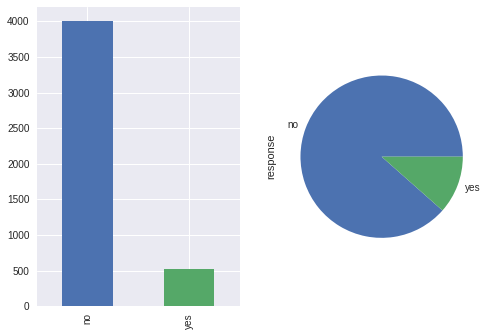

In [0]:
# Visualize volume of no vs yes
plt.subplot(1, 2, 1)
bank['response'].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
bank['response'].value_counts().plot(kind='pie')
plt.show()

#### Correlation Analysis

<Figure size 576x396 with 0 Axes>

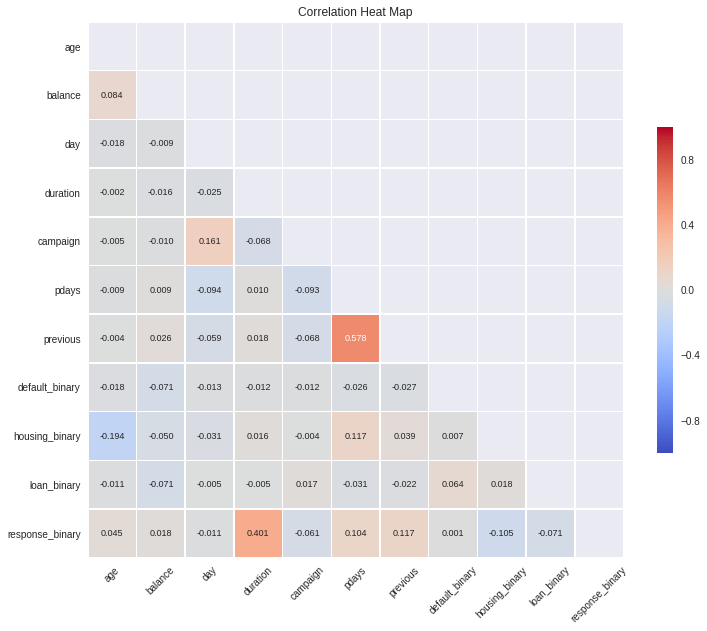

In [0]:
# Build a correlation chart to attempt to see which variables may be 
# most influential on responses
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)   

corr_chart(df_corr = bank)

Here we can see that there are correlations levels that we may need to take into account, which aren't in our current model_data array. Duration, pdays, and previous appear to have some bearing on the response value. We can also see that previous and pdays have some level of correlation.

# Model Preparation

### Define Model Parameters

In [0]:
# cross-validation scoring code adapted from Scikit Learn documentation
from sklearn.metrics import roc_auc_score

# specify the set of classifiers being evaluated
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
names = ["Naive_Bayes", "Logistic_Regression"]
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5,
                           class_prior = [0.5, 0.5], fit_prior=False),
               LogisticRegression(solver='lbfgs')]

### Select Data for Model Array

In [0]:
# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(bank['default_binary']), 
                       np.array(bank['housing_binary']), 
                       np.array(bank['loan_binary']),
                       np.array(bank['response'])]).T

### Initial Dataset Training and ROC Calculation

In [0]:
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
import scikitplot as skplt

# ten-fold cross-validation employed here
N_FOLDS = 10

bayes_max=[0,[],[]]
logistic_max=[0,[],[]]

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized
for train_index, test_index in kf.split(model_data):
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1])
        cv_results[index_for_fold, index_for_method] = fold_method_result
        if name == 'Naive_Bayes' and fold_method_result > bayes_max[0]:
          bayes_max[0] = fold_method_result
          bayes_max[1] = y_test
          bayes_max[2] = y_test_predict
        if name == 'Logistic_Regression' and fold_method_result > logistic_max[0]:
          logistic_max[0] = fold_method_result
          logistic_max[1] = y_test
          logistic_max[2] = y_test_predict
        index_for_method += 1
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names
cv_results_df.index.name = 'Fold Number'
cv_results_df

,Naive_Bayes,Logistic_Regression
Fold Number,,
0,0.587852,0.587852
1,0.633728,0.633728
2,0.657535,0.657535
3,0.637388,0.635565
4,0.574399,0.574399
5,0.574684,0.584238
6,0.562512,0.562512
7,0.731144,0.731144
8,0.573533,0.573533


In [0]:
cv_results_df.mean().to_frame(name='Average ROC from 10 Folds')

,Average ROC from 10 Folds
Naive_Bayes,0.611060
Logistic_Regression,0.611733


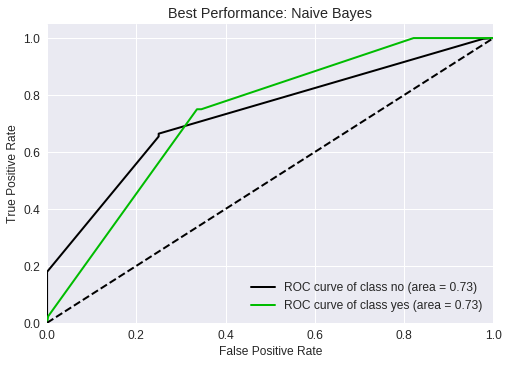

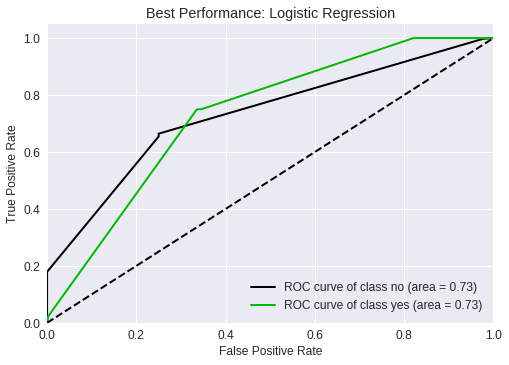

In [0]:
skplt.metrics.plot_roc(bayes_max[1], bayes_max[2], plot_micro=False, plot_macro=False, title="Best Performance: Naive Bayes")
skplt.metrics.plot_roc(logistic_max[1], logistic_max[2], plot_micro=False, plot_macro=False, title="Best Performance: Logistic Regression")
plt.show()

### Select Alternative Data for Model Array

Based on our findings in the EDA phase, we can identify data which has a higher level of correlation, the therfore hopefully a higher level of predictibility.

In [0]:
# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data_alternative = np.array([np.array(bank['duration']), 
# As duration and pdays are highly correlated already, we don't need to include 
# Them both, this will also help to avoid overfitting
                       #np.array(bank['pdays']), 
                       np.array(bank['previous']),
                       np.array(bank['housing_binary']),
                       np.array(bank['response'])]).T

### Alternative Dataset Training and ROC Calculation

In [0]:
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
import scikitplot as skplt

# ten-fold cross-validation employed here
N_FOLDS = 10

bayes_max=[0,[],[]]
logistic_max=[0,[],[]]

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized
for train_index, test_index in kf.split(model_data_alternative):
#   note that 0:model_data_alternative.shape[1]-1 slices for explanatory variables
#   and model_data_alternative.shape[1]-1 is the index for the response variable
    X_train = model_data_alternative[train_index, 0:model_data_alternative.shape[1]-1]
    X_test = model_data_alternative[test_index, 0:model_data_alternative.shape[1]-1]
    y_train = model_data_alternative[train_index, model_data_alternative.shape[1]-1]
    y_test = model_data_alternative[test_index, model_data_alternative.shape[1]-1]

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1])
        cv_results[index_for_fold, index_for_method] = fold_method_result
        if name == 'Naive_Bayes' and fold_method_result > bayes_max[0]:
          bayes_max[0] = fold_method_result
          bayes_max[1] = y_test
          bayes_max[2] = y_test_predict
        if name == 'Logistic_Regression' and fold_method_result > logistic_max[0]:
          logistic_max[0] = fold_method_result
          logistic_max[1] = y_test
          logistic_max[2] = y_test_predict
        index_for_method += 1
    index_for_fold += 1
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names
cv_results_df.index.name = 'Fold Number'
cv_results_df

,Naive_Bayes,Logistic_Regression
Fold Number,,
0,0.602738,0.835460
1,0.609392,0.868227
2,0.669876,0.786955
3,0.661290,0.830075
4,0.631462,0.869020
5,0.699128,0.873450
6,0.628397,0.823004
7,0.722120,0.858902
8,0.618173,0.818225


In [0]:
cv_results_df.mean().to_frame(name='Average ROC from 10 Folds')

,Average ROC from 10 Folds
Naive_Bayes,0.645790
Logistic_Regression,0.839955


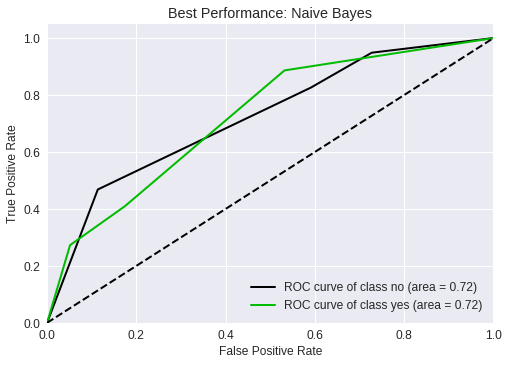

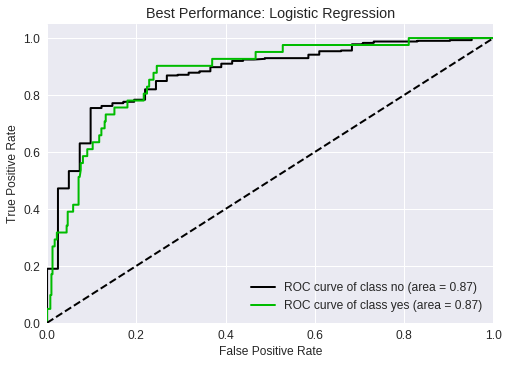

In [0]:
skplt.metrics.plot_roc(bayes_max[1], bayes_max[2], plot_micro=False, plot_macro=False, title="Best Performance: Naive Bayes")
skplt.metrics.plot_roc(logistic_max[1], logistic_max[2], plot_micro=False, plot_macro=False, title="Best Performance: Logistic Regression")
plt.show()

# Recommendations

By identifying important datapoints in the EDA phase, we were able to build a Logistic Regression model input that is roughly 84% accurate. This model should be utilized to optimize marketing activities and ensure the highest ROI.

Answers to the questions posed at the beginning of this project are listed below:

**What kinds of clients are most likely to subscribe to new term deposits?**
1.   Customers who do not have a housing loan, meaning that their housing value is set to 'no'
2.   Customers who have the marketing patterns listed in the next section

**What marketing approaches are most effective in encouraging clients to subscribe?**
1.   Customers who have not been marketed to recently, meaning that they have a higher pday value
2.   Customers who are more engaged during marketing contact events, meaning that they have a higher duration value
3.   Customers who have been marketed to more frequently, meaning that they have a higher previous value

**Which of the two modeling methods would you recommend and why?**
1.   The Logistic Regression model performed much better in terms of predictive power then the Naive Bayes classification did when the correct input data was selected. 

**Which group of banking clients appears to be the best target for direct marketing efforts?**
1.   Customers who have the personal attributes and marketing frequency outlined above.